# HEX UCR Dataset: 177_UCR_Anomaly_insectEPG5_3200_8500_8501

**Dataset Link:** https://www.cs.ucr.edu/~eamonn/time_series_data_2018/UCR_TimeSeriesAnomalyDatasets2021.zip

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Anomaly Detection (LSTM-AE) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-up2haipz3j472).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "ALGO_ARN"

In [2]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Data preparation

Load the data.

In [3]:
dataset_name = "177_UCR_Anomaly_insectEPG5_3200_8500_8501"
cutoff = 3200  # train-test cutoff
start = 8500   # start of anomalous time interval
end = 8530     # end of anomalous time interval
k = 1          # number of anomalies to extract

In [4]:
dataset = pd.DataFrame(data=np.genfromtxt(f"{dataset_name}.txt"))

In [5]:
dataset.shape

(10028, 1)

In [6]:
dataset.head()

,0
0,0.209960
1,0.216060
2,0.212400
3,0.174560
4,-0.009766


In [7]:
dataset.tail()

,0
10023,0.113530
10024,-0.029297
10025,-0.198970
10026,-0.230710
10027,-0.223390


Visualize the data.

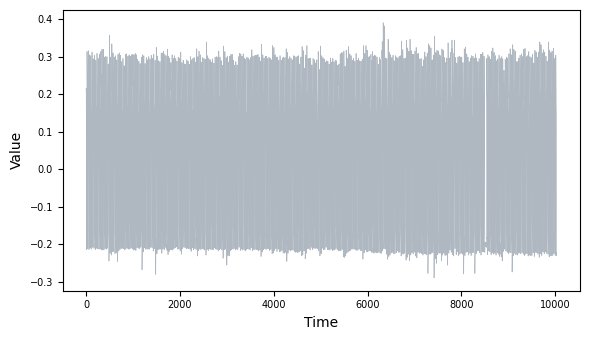

In [8]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(dataset, color="#AFB8C1", lw=0.5)
ax.set(xlabel="Time", ylabel="Value")
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Split the data.

In [9]:
training_dataset = dataset.iloc[:cutoff]

In [10]:
training_dataset.shape

(3200, 1)

In [11]:
test_dataset = dataset.iloc[cutoff:]

In [12]:
test_dataset.shape

(6828, 1)

Upload the data to S3.

In [13]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key=f"{dataset_name}_train.csv"
)

In [14]:
training_data

's3://sagemaker-eu-west-1-661670223746/177_UCR_Anomaly_insectEPG5_3200_8500_8501_train.csv'

In [15]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key=f"{dataset_name}_test.csv"
)

In [16]:
test_data

's3://sagemaker-eu-west-1-661670223746/177_UCR_Anomaly_insectEPG5_3200_8500_8501_test.csv'

### 3. Training

Fit the model to the training set.

In [17]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "sequence-length": 30,
        "sequence-stride": 30,
        "hidden-size": 64,
        "lr": 0.0001,
        "batch-size": 16,
        "epochs": 200,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: lstm-ae-v1-4-2023-12-10-19-27-31-805


2023-12-10 19:27:32 Starting - Starting the training job...
2023-12-10 19:27:47 Starting - Preparing the instances for training......
2023-12-10 19:28:52 Downloading - Downloading input data...
2023-12-10 19:29:12 Training - Downloading the training image...............
2023-12-10 19:31:43 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-10 19:32:08,570 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-10 19:32:08,571 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-10 19:32:08,571 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-12-10 19:32:08,582 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-12-10 19:32:08,584 sagemaker_pytorch_container.training INFO     Invoking u

### 4. Inference

Generate the test set reconstructions.

In [18]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: lstm-ae-v1-4-2023-12-10-19-33-16-460


.........

INFO:sagemaker:Creating model with name: lstm-ae-v1-4-2023-12-10-19-33-16-460-2023-12-10-19-34-01-871


INFO:sagemaker:Creating transform job with name: lstm-ae-v1-4-2023-12-10-19-34-04-674


2023-12-10T19:41:17,157 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2023-12-10T19:41:17,159 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-12-10T19:41:17,219 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-12-10T19:41:17,320 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.2
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Infer

Load the test set reconstructions from S3.

In [19]:
reconstructions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/{dataset_name}_test.csv.out"
)

In [20]:
reconstructions = pd.DataFrame([x.split(",") for x in reconstructions.split("\n")[:-1]]).replace("", np.nan).astype(float)

In [21]:
reconstructions.shape

(6828, 2)

In [22]:
reconstructions.head()

,0,1
0,1.268174,0.187886
1,0.470492,0.182227
2,0.468629,0.150731
3,3.057650,0.056491
4,1.549613,-0.084204


In [23]:
reconstructions.tail()

,0,1
6823,NaN,NaN
6824,NaN,NaN
6825,NaN,NaN
6826,NaN,NaN
6827,NaN,NaN


Extract the anomalous time steps.

In [24]:
anomalies = reconstructions.iloc[:, 0].sort_values(ascending=False).iloc[:k].index.to_series()

In [25]:
anomalies.values

array([5314])

Check if the anomalous time steps are within the anomalous time interval.

In [26]:
anomalies.between(start - cutoff, end - cutoff).values

array([ True])

Visualize the reconstructions.

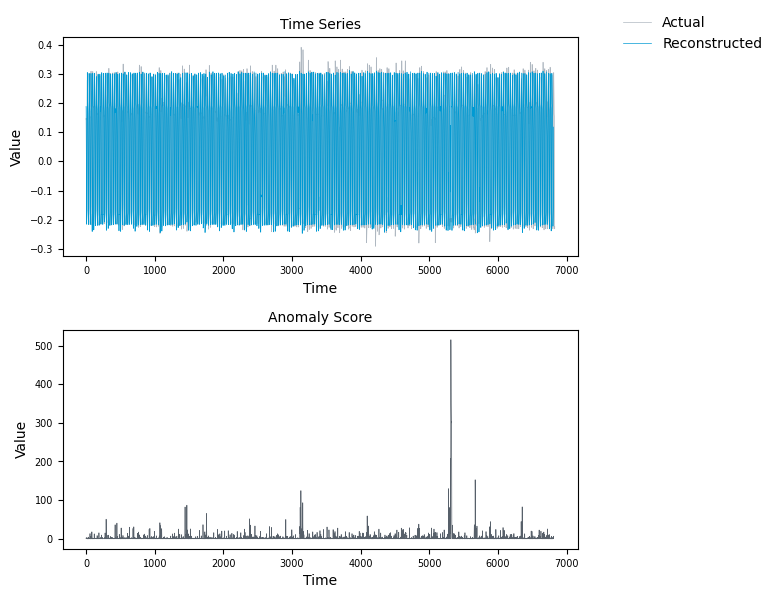

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 6))

axs[0].set_title("Time Series", size=10)
axs[0].plot(test_dataset.iloc[:, 0].values, color="#AFB8C1", lw=0.5, label="Actual")
axs[0].plot(reconstructions.iloc[:, 1], color="#009ad3", lw=0.5, label="Reconstructed")
axs[0].set(xlabel="Time", ylabel="Value")
axs[0].xaxis.set_tick_params(labelbottom=True)
axs[0].tick_params(axis="both", which="major", labelsize=7)
axs[0].tick_params(axis="both", which="minor", labelsize=7)

axs[1].set_title("Anomaly Score", size=10)
axs[1].plot(reconstructions.iloc[:, 0], color="#57606a", lw=0.5)
axs[1].set(xlabel="Time", ylabel="Value")
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].tick_params(axis="both", which="major", labelsize=7)
axs[1].tick_params(axis="both", which="minor", labelsize=7)

fig.tight_layout()
fig.legend(bbox_to_anchor=(1.3, 1, 0, 0), frameon=False)
fig.show()